In [15]:
# Sometimes a two sets of experimental data share all or some of the same model
# parameters.  Consider, for example, the LRC resonator.  One could measure
# both the magnitude and phase of the voltage across the resistor as a
# function of frequency.  Both of these quantities depend on the resonant
# frequency of the system and a loss parameter.  The magnitude and phase
# data could be fit independently to determine two sets of the parameters.
# Perhaps you could then take a weighted average of the results to produce
# a single 'best' value for the resonant frequency and loss parameter.
# However, a better approach is to simultaneously fit the two data sets and
# directly extract a single best-fit value for each parameter.  This
# tutorial shows you how to implement a simultaneous fit to multiple data
# sets that, each have their own model, but share at least some of the
# same best-fit parameters.

# This script is based on one developed by Jonathan J. Helmus in 2013.  Here 
# is a link to the code that was posted online: 
# https://mail.python.org/pipermail/scipy-user/2013-April/034403.html

# I modified the code so that we could do a weighted fit and then extract 
# uncertainty estimates for the best-fit parameters.

In [16]:
# Import some standard modules.
import numpy as np
import matplotlib.pyplot as plt

In [17]:
# Import the data and plot it.  The data file has three columns: 
# 1. frequency, 2. real component of S11, and 3. imaginary component of S11.
# S11 is a reflection coefficient.
M = np.loadtxt("S11 - real imag.dat")
fdata = M[:, 0]
Sreal = M[:, 1]
Simag = M[:, 2]

In [18]:
# To demonstrate the implementation of a weighted fit, I define two vectors 
# which will be used as uncertainties in the measured values.  One for the 
# real component of S11 and one for the imaginary component of S11.
x = np.ones(int((len(fdata) - 1)/2))
y = np.ones(int((len(fdata) - 1)/2 + 1))
errReData = np.concatenate([0.1*x] + [0.2*y])
errImData = np.concatenate([0.05*x] + [0.3*y])
print(errReData)
print(errImData)

[0.1 0.1 0.1 ... 0.2 0.2 0.2]
[0.05 0.05 0.05 ... 0.3  0.3  0.3 ]


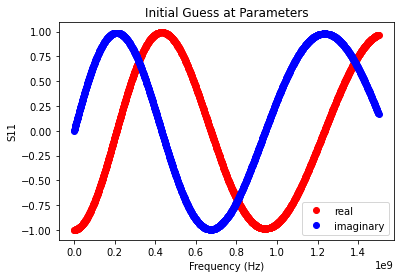

In [19]:
# Here's the plot of the experimental data.
plt.plot(fdata, Sreal, 'or')
plt.plot(fdata, Simag, 'ob')
plt.xlabel('Frequency (Hz)');
plt.ylabel('S11');
plt.title('Initial Guess at Parameters');
plt.legend(('real','imaginary'));

In [20]:
# To do the fitting, we need to define the models that the two data sets will
# be fit to.  The real component of S11 will be fit to 'ReS()' and the imaginary
# component will be fit to 'ImS()'.  The input 'p' will be a list to the two fit
# parameters.  Our parameters will be L1 (the inductance of a loop of wire) and
# q which is related to the propagation constant for signals in a coaxial 
# cable.  Z0 = 50 ohms is the characteristic impedance of the coaxial cable.
Z0 = 50

In [21]:
# Here's the model for the real component of the data.
def ReS(p, freq): 
    L1, q = p
    Xin = Z0*(2*np.pi*freq*L1/Z0 + np.tan(q*freq))/(1-(2*np.pi*freq*L1/Z0)*np.tan(q*fdata))
    return ((Xin/Z0)**2 - 1)/((Xin/Z0)**2 + 1)

In [22]:
# Here's the model for the imaginary component of the data.
def ImS(p, freq):    
    L1, q = p
    Xin = Z0*(2*np.pi*freq*L1/Z0 + np.tan(q*freq))/(1-(2*np.pi*freq*L1/Z0)*np.tan(q*fdata))
    return 2*(Xin/Z0)/((Xin/Z0)**2 + 1)

In [23]:
# When we do the fit we will have to supply initial guesses for the parameter
# values.  It is good practice to try some values and compare the model functions
# to the experimental data.  That way we can be sure that we're starting
# will reasonable initial values.  The guesses don't need to be perfect, just good
# enough to get the minimization rountine started on a good trajectory.
gL1 = 0.2e-9 # henries
gq = 3.2e-9 # seconds

In [24]:
# Make the list of initial parameter guesses.
params = [gL1, gq]

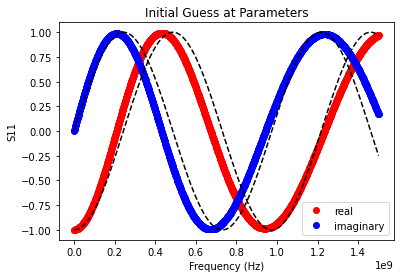

In [26]:
# Use the functions that we defined to plot the theoretical curves on top of 
# the data.

# First, reproduce the plot of the experimental data.
plt.plot(fdata, Sreal, 'or')
plt.plot(fdata, Simag, 'ob')
plt.xlabel('Frequency (Hz)');
plt.ylabel('S11');
plt.title('Initial Guess at Parameters');
plt.legend(('real','imaginary'));

# Then add the lines defined by the two functions.
plt.plot(fdata, ReS(params, fdata), 'k--')
plt.plot(fdata, ImS(params, fdata), 'k--');

In [27]:
# Next, we define our error functions to be minimized.  Ultimately, we will
# use 'scipy.optimize.leastsq()' to minimize the sum of the squares of the 
# elements in our final error function.  The basic error function is just the 
# difference between the theoretically-calculated y-values and the measured
# #y-values.  For the real data, that would be 'Res() - Sreal'.  To do a 
# fit weighted, we want points with small error bars have greater importance
# in the sum.  This is acheived by dividing each term in the sum by the 
# experimental uncertainty in the measured point.  In this way, the final error
# function becomes '(Res() - Sreal)/errReData'.  To implement this in Python
# we define an error function which relies on the function already defined
# for the best-fit model.
def errRe(p, freq, yRe, sigmaRe):
    return (ReS(p, freq) - yRe)/sigmaRe

In [28]:
# We have an equivalent error function for the imaginary component of the data.
def errIm(p, freq, yIm, sigmaIm):
    return (ImS(p, freq) - yIm)/sigmaIm

In [29]:
# The final 'global' error function is the combination of 'errRe()' and 'errIm()'.
# In this way, 'scipy.optimize.leastsq()' will be required to adjust the
# fit parameters to simultaneously minimize to total net deviation between the
# fit curves and the experimental data, weighted by the experimental 
# uncertainties, for both data sets
def err_global(p, freq, yRe, yIm, sigmaRe, sigmaIm):
    err1 = errRe(p, freq, yRe, sigmaRe)
    err2 = errIm(p, freq, yIm, sigmaIm)
    return np.concatenate((err1, err2))

In [30]:
# Here is the implementation of the actual minimization routine.
# The important outputs are 'p_best' which will be a list of the best-fit parameters
# and 'pcov' which will be used to estimate the uncertainties in the fit values.
# To run the minimization function, the inputs that we need to provide are:
# 1. The global error function, which depends on all of the other functions that
#    we defined.
# 2. The list of initial guesses - which we called 'params'.
# 3. The x-data, the two y-data sets, and the uncertainties in those y-data.
#    All of these inputs are given within 'args = ( ... )'.
import scipy.optimize
p_best, pcov, infodict, errmsg, success = scipy.optimize.leastsq(err_global,\
            params, args=(fdata, Sreal, Simag, errReData, errImData),  full_output = 1)

In [31]:
# Here are the best-fit values.
L1_fit = p_best[0]
q_fit = p_best[1]
print('L1 =', L1_fit/1e-9, 'nH and q =', q_fit/1e-9, 'ns.')

L1 = 11.871185464679385 nH and q = 2.3189356106454824 ns.


In [32]:
# To get error estimates of the best-fit values, we usually take the square
# root of the diagonal elements of the covariance matrix.
# According to the 'scipy.optimize.leastsq()' documentation:
#
#   To obtain the covariance matrix of the parameters x, cov_x must be 
#   multiplied by the variance of the residuals – see curve_fit.
#
# In this next line, we calculate this sum so that we can properly scale
# the 'pcov' output from 'scipy.optimize.leastsq()'.
res_sq = (err_global(p_best, fdata, Sreal, Simag, errReData, errImData)**2).sum()\
    /(len(fdata)-len(p_best))

In [34]:
# Finally, we get the error estimates from the square root of the diagonal
# elements of the scaled covariance matrix.
dL1 = np.sqrt(pcov[0][0]*res_sq)
dq = np.sqrt(pcov[1][1]*res_sq)

print('The best-fit parameters are:\
      \n L1 \u00B1 \u0394L1 =', L1_fit/1e-9, '\u00B1', dL1/1e-9, 'nH'\
     '\n q \u00B1 \u0394q =', q_fit/1e-9, '\u00B1', dq/1e-9, 'ns')

The best-fit parameters are:      
 L1 ± ΔL1 = 11.871185464679385 ± 0.011297172968175824 nH
 q ± Δq = 2.3189356106454824 ± 0.0007503444807940306 ns


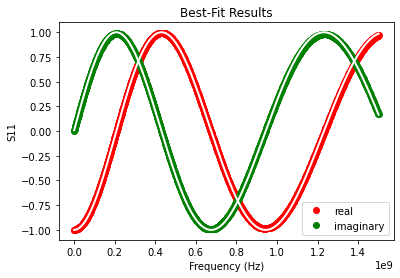

In [35]:
# Let's added the best-fit curves (white lines) to the plot of the experimental
# data.

# Here's the data.
plt.plot(fdata, Sreal, 'or')
plt.plot(fdata, Simag, 'og')
plt.xlabel('Frequency (Hz)');
plt.ylabel('S11');
plt.title('Best-Fit Results');
plt.legend(('real','imaginary'))

# Here are the best-fit lines.
plt.plot(fdata, ReS(p_best, fdata), 'w-', linewidth = 2)
plt.plot(fdata, ImS(p_best, fdata), 'w-', linewidth = 2);